# Group Chat

Group chat is a design pattern where a group of agents share a common thread
of messages: they all subscribe and publish to the same topic. 
Each participant agent is specialized for a particular task, 
such as writer, illustrator, and editor
in a collaborative writing task.
You can also include an agent to represent a human user to help guide the
agents when needed.

In a group chat, participants take turn to publish a message, and the process
is sequential -- only one agent is working at a time.
Under the hood, the order of turns is maintained by a Group Chat Manager agent,
which selects the next agent to speak upon receving a message.
The exact algorithm for selecting the next agent can vary based on your
application requirements. 
Typically, a round-robin algorithm or a selector with an LLM model is used.

Group chat is useful for dynamically decomposing a complex task into smaller ones 
that can be handled by specialized agents with well-defined roles.
It is also possible to nest group chats into a hierarchy with each participant
a recursive group chat.

In this example, we use AutoGen's Core API to implement the group chat pattern
using event-driven agents.
Please first read about [Topics and Subscriptions](../core-concepts/topic-and-subscription.md)
to understand the concepts and then [Messages and Communication](../framework/message-and-communication.ipynb)
to learn the API usage for pub-sub.
We will demonstrate a simple example of a group chat with a LLM-based selector
for the group chat manager, to create content for a children's story book.

```{note}
While this example illustrates the group chat mechanism,
the [AgentChat API](../../agentchat-user-guide/index.md) has a built-in implementation
of selector group chat. You can use that if you do not want to learn the Core API.
```

We will be using the [rich](https://github.com/Textualize/rich) library to display the messages in a nice format.

In [11]:
# ! pip install rich

In [12]:
import json
import uuid
import string
from typing import List

import openai
from rich.console import Console
from rich.markdown import Markdown
from autogen_core.application import SingleThreadedAgentRuntime
from autogen_core.base import MessageContext, TopicId
from autogen_core.components import (
    DefaultTopicId,
    FunctionCall,
    Image,
    RoutedAgent,
    TypeSubscription,
    message_handler,
)
from autogen_core.components.models import (
    AssistantMessage,
    ChatCompletionClient,
    LLMMessage,
    OpenAIChatCompletionClient,
    SystemMessage,
    UserMessage,
)
from autogen_core.components.tools import FunctionTool
from IPython.display import display  # type: ignore
from pydantic import BaseModel

## Message Protocol

The message protocol for the group chat pattern is simple.
1. To start, user or an external agent publishes a `GroupChatMessage` message to the common topic of all participants.
2. The group chat manager selects the next speaker, sends out a `RequestToSpeak` message to that agent.
3. The agent publishes a `GroupChatMessage` message to the common topic upon receiving the `RequestToSpeak` message.
4. This process continues until a termination condition is reached at the group chat manager, which then stops issuing `RequestToSpeak` message, and the group chat ends.

In [13]:
class GroupChatMessage(BaseModel):
    body: UserMessage


class RequestToSpeak(BaseModel):
    pass

## Agents

Let's first define the agent class that only uses LLM models to generate text.
This is for the writer and editor.

In [14]:
class ChatAgent(RoutedAgent):
    """A group chat participant using an LLM."""

    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        system_message: str,
    ) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type
        self._model_client = model_client
        self._system_message = SystemMessage(system_message)
        self._chat_history: List[LLMMessage] = []

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        self._chat_history.extend(
            [
                UserMessage(content=f"Transferred to {message.body.source}", source="system"),
                message.body,
            ]
        )

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        completion = await self._model_client.create([self._system_message] + self._chat_history)
        assert isinstance(completion.content, str)
        self._chat_history.append(AssistantMessage(content=completion.content, source=self.id.type))
        Console().print(Markdown(completion.content))
        # print(completion.content, flush=True)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=completion.content, source=self.id.type)),
            topic_id=DefaultTopicId(type=self._group_chat_topic_type),
        )

In [15]:
class WriterAgent(ChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are a Writer. You produce good work.",
        )


class EditorAgent(ChatAgent):
    def __init__(self, description: str, group_chat_topic_type: str, model_client: ChatCompletionClient) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Editor. Plan and guide the task given by the user. Provide critical feedbacks to the draft and illustration produced by Writer and Illustrator. "
            "Approve if the task is completed and the draft and illustration meets user's requirements.",
        )

Now let's define the `IllustratorAgent` which uses a DALL-E model to generate
an illustration based on the description provided.
We set up the image generator as a tool using {py:class}`~autogen_core.components.tools.FunctionTool`
wrapper, and use a model client to make the tool call.

In [16]:
class IllustratorAgent(ChatAgent):
    def __init__(
        self,
        description: str,
        group_chat_topic_type: str,
        model_client: ChatCompletionClient,
        image_client: openai.AsyncClient,
    ) -> None:
        super().__init__(
            description=description,
            group_chat_topic_type=group_chat_topic_type,
            model_client=model_client,
            system_message="You are an Illustrator. You use the generate_image tool to create images given user's requirement.",
        )
        self._image_client = image_client
        self._image_gen_tool = FunctionTool(
            self._image_gen,
            name="generate_image",
            description="Call this to generate an image given a text description.",
        )

    async def _image_gen(self, description: str) -> str:
        response = await self._image_client.images.generate(
            prompt=description.strip(), model="dall-e-2", response_format="b64_json", size="256x256"
        )
        return response.data[0].b64_json  # type: ignore

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        # print(f"\n{'-'*80}\n{self.id.type}:", flush=True)
        Console().print(Markdown(f"### {self.id.type}: "))
        self._chat_history.append(
            UserMessage(content=f"Transferred to {self.id.type}, adopt the persona immediately.", source="system")
        )
        # Ensure that the image generation tool is used.
        completion = await self._model_client.create(
            [self._system_message] + self._chat_history,
            tools=[self._image_gen_tool],
            extra_create_args={"tool_choice": "required"},
            cancellation_token=ctx.cancellation_token,
        )
        assert isinstance(completion.content, list) and all(
            isinstance(item, FunctionCall) for item in completion.content
        )
        images: List[str | Image] = []
        for tool_call in completion.content:
            arguments = json.loads(tool_call.arguments)
            # print(arguments["description"], flush=True)
            Console().print(Markdown(arguments['description']))
            result = await self._image_gen_tool.run_json(arguments, ctx.cancellation_token)
            image = Image.from_base64(self._image_gen_tool.return_value_as_string(result))
            display(image.image)  # type: ignore
            images.append(image)
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=images, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

With all the AI agents defined, we can now define the user agent that will
take the role of the human user in the group chat.

The `UserAgent` implementation uses console input to get the user's input.
In a real-world scenario, you can replace this by communicating with a frontend,
and subscribe to responses from the frontend.

In [17]:
class UserAgent(RoutedAgent):
    def __init__(self, description: str, group_chat_topic_type: str) -> None:
        super().__init__(description=description)
        self._group_chat_topic_type = group_chat_topic_type

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        # When integrating with a frontend, this is where group chat message would be sent to the frontend.
        pass

    @message_handler
    async def handle_request_to_speak(self, message: RequestToSpeak, ctx: MessageContext) -> None:
        user_input = input("Enter your message, type 'APPROVE' to conclude the task: ")
        Console().print(Markdown(f"### User: \n{user_input}"))
        await self.publish_message(
            GroupChatMessage(body=UserMessage(content=user_input, source=self.id.type)),
            DefaultTopicId(type=self._group_chat_topic_type),
        )

Lastly, we define the `GroupChatManager` agent which manages the group chat
and selects the next agent to speak using an LLM.
The group chat manager checks if the editor has approved the draft by 
looking for the `"APPORVED"` keyword in the message. If the editor has approved
the draft, the group chat manager stops selecting the next speaker, and the group chat ends.

The group chat manager's constructor takes a list of participants' topic types
as an argument.
To prompt the next speaker to work, 
the it publishes a `RequestToSpeak` message to the next participant's topic.

In this example, we also make sure the group chat manager always picks a different
participant to speak next, by keeping track of the previous speaker.
This helps to ensure the group chat is not dominated by a single participant.

In [18]:
class GroupChatManager(RoutedAgent):
    def __init__(
        self,
        participant_topic_types: List[str],
        model_client: ChatCompletionClient,
        participant_descriptions: List[str],
    ) -> None:
        super().__init__("Group chat manager")
        self._participant_topic_types = participant_topic_types
        self._model_client = model_client
        self._chat_history: List[UserMessage] = []
        self._participant_descriptions = participant_descriptions
        self._previous_participant_topic_type: str | None = None

    @message_handler
    async def handle_message(self, message: GroupChatMessage, ctx: MessageContext) -> None:
        assert isinstance(message.body, UserMessage)
        self._chat_history.append(message.body)
        # If the message is an approval message from the user, stop the chat.
        if message.body.source == "User":
            assert isinstance(message.body.content, str)
            if message.body.content.lower().strip(string.punctuation).endswith("approve"):
                return
        # Format message history.
        messages: List[str] = []
        for msg in self._chat_history:
            if isinstance(msg.content, str):
                messages.append(f"{msg.source}: {msg.content}")
            elif isinstance(msg.content, list):
                line: List[str] = []
                for item in msg.content:
                    if isinstance(item, str):
                        line.append(item)
                    else:
                        line.append("[Image]")
                messages.append(f"{msg.source}: {', '.join(line)}")
        history = "\n".join(messages)
        # Format roles.
        roles = "\n".join(
            [
                f"{topic_type}: {description}".strip()
                for topic_type, description in zip(
                    self._participant_topic_types, self._participant_descriptions, strict=True
                )
                if topic_type != self._previous_participant_topic_type
            ]
        )
        selector_prompt = """You are in a role play game. The following roles are available:
{roles}.
Read the following conversation. Then select the next role from {participants} to play. Only return the role.

{history}

Read the above conversation. Then select the next role from {participants} to play. Only return the role.
"""
        system_message = SystemMessage(
            selector_prompt.format(
                roles=roles,
                history=history,
                participants=str(
                    [
                        topic_type
                        for topic_type in self._participant_topic_types
                        if topic_type != self._previous_participant_topic_type
                    ]
                ),
            )
        )
        completion = await self._model_client.create([system_message], cancellation_token=ctx.cancellation_token)
        assert isinstance(completion.content, str)
        selected_topic_type: str
        for topic_type in self._participant_topic_types:
            if topic_type.lower() in completion.content.lower():
                selected_topic_type = topic_type
                self._previous_participant_topic_type = selected_topic_type
                await self.publish_message(RequestToSpeak(), DefaultTopicId(type=selected_topic_type))
                return
        raise ValueError(f"Invalid role selected: {completion.content}")

## Creating the Group Chat

To set up the group chat, we create an {py:class}`~autogen_core.application.SingleThreadedAgentRuntime`
and register the agents' factories and subscriptions.

Each participant agent subscribes to both the group chat topic as well as its own
topic in order to receive `RequestToSpeak` messages, 
while the group chat manager agent only subcribes to the group chat topic.

In [19]:
runtime = SingleThreadedAgentRuntime()

editor_topic_type = "Editor"
writer_topic_type = "Writer"
illustrator_topic_type = "Illustrator"
user_topic_type = "User"
group_chat_topic_type = "group_chat"

editor_description = "Editor for planning and reviewing the content."
writer_description = "Writer for creating any text content."
user_description = "User for providing final approval."
illustrator_description = "An illustrator for creating images."

editor_agent_type = await EditorAgent.register(
    runtime,
    editor_topic_type,  # Using topic type as the agent type.
    lambda: EditorAgent(
        description=editor_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=editor_topic_type, agent_type=editor_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=editor_agent_type.type))

writer_agent_type = await WriterAgent.register(
    runtime,
    writer_topic_type,  # Using topic type as the agent type.
    lambda: WriterAgent(
        description=writer_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(TypeSubscription(topic_type=writer_topic_type, agent_type=writer_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=writer_agent_type.type))

illustrator_agent_type = await IllustratorAgent.register(
    runtime,
    illustrator_topic_type,
    lambda: IllustratorAgent(
        description=illustrator_description,
        group_chat_topic_type=group_chat_topic_type,
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        image_client=openai.AsyncClient(
            # api_key="YOUR_API_KEY",
        ),
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=illustrator_topic_type, agent_type=illustrator_agent_type.type)
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=illustrator_agent_type.type)
)

user_agent_type = await UserAgent.register(
    runtime,
    user_topic_type,
    lambda: UserAgent(description=user_description, group_chat_topic_type=group_chat_topic_type),
)
await runtime.add_subscription(TypeSubscription(topic_type=user_topic_type, agent_type=user_agent_type.type))
await runtime.add_subscription(TypeSubscription(topic_type=group_chat_topic_type, agent_type=user_agent_type.type))

group_chat_manager_type = await GroupChatManager.register(
    runtime,
    "group_chat_manager",
    lambda: GroupChatManager(
        participant_topic_types=[writer_topic_type, illustrator_topic_type, editor_topic_type, user_topic_type],
        model_client=OpenAIChatCompletionClient(
            model="gpt-4o-2024-08-06",
            # api_key="YOUR_API_KEY",
        ),
        participant_descriptions=[writer_description, illustrator_description, editor_description, user_description],
    ),
)
await runtime.add_subscription(
    TypeSubscription(topic_type=group_chat_topic_type, agent_type=group_chat_manager_type.type)
)

## Running the Group Chat

We start the runtime and publish a `GroupChatMessage` for the task to start the group chat.

Writer:

Title: The Adventurous Journey of the Gingerbread Man                                                              

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 1:                                                                                                            

(Artwork: Cozy kitchen with a grandmotherly figure rolling out dough.)                                             

Text: In a snug little kitchen, Grandma mixed and rolled a special batch of gingerbread dough. With care and       
creativity, she shaped a jolly gingerbread man and popped him into the oven.                                       

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 2:                                                                                                            

(Artwork: The gingerbread man springing from the baking tray with tiny arms up in excitement.)                     

Text: When the timer rang, out jumped the gingerbread man with a cheerful grin. "I'm alive!" he exclaimed, tipping 
his imaginary hat to Grandma and dashing out of the door.                                                          

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 3:                                                                                                            

(Artwork: The gingerbread man sprinting through a garden, passing a curious rabbit.)                               

Text: Past tulips and alliums he ran, with nimble feet and a sprightly step. "Run, run, as fast as you can! You    
can't catch me, I'm the gingerbread man!" he sang with glee, waving to a rabbit who looked on with wonder.         

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 4:                                                                                                            

(Artwork: The gingerbread man crossing a tiny wooden bridge as a dog chases from behind.)                          

Text: Over the bridge and through the tall grass, a playful puppy gave chase. But the gingerbread man was much too 
quick. "Run, run, as fast as you can! You can't catch me, I'm the gingerbread man!" he echoed, his voice carried on
the soft breeze.                                                                                                   

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 5:                                                                                                            

(Artwork: The gingerbread man hopping over a meadow, pursued by a tired rooster.)                                  

Text: Further along, a boisterous rooster joined the pursuit. Yet, our gingerbread hero leapt ahead, light as a    
feather on the wind. "Run, run, as fast as you can!" he declared, for his path was clear and wide.                 

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 6:                                                                                                            

(Artwork: The gingerbread man pausing beside a gentle river, contemplating safe passage with a fox nearby.)        

Text: At the river's edge, the gingerbread man pondered, "How will I cross this flowing stream?" A sly fox         
approached, offering kindly, "Hop on my back, and I'll help you dream."                                            

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Page 7:                                                                                                            

(Artwork: The gingerbread man dancin

Illustrator:

A cozy kitchen with a grandmotherly figure rolling out dough. The atmosphere is warm and inviting, with various    
baking utensils around.

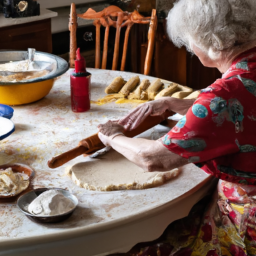

A gingerbread man springing to life from the baking tray, with tiny arms up in excitement. The kitchen background  
adds a lively touch to the scene.

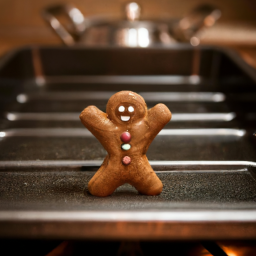

The gingerbread man running through a colorful garden, passing a curious rabbit. The scene is filled with vibrant  
flowers and greenery.

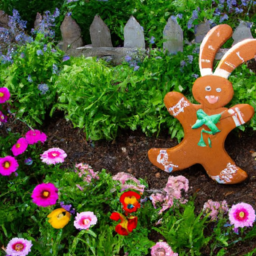

The gingerbread man sprinting over a tiny wooden bridge, with a playful dog chasing after him. The landscape is    
sunny and cheerful.

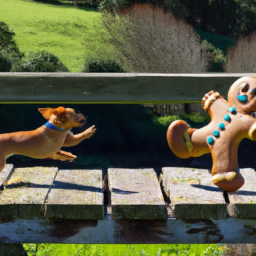

The gingerbread man hopping over a wide meadow with a tired rooster in pursuit. The scenery is open and            
picturesque.

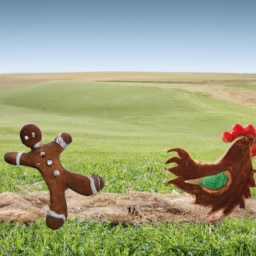

The gingerbread man pausing beside a gently flowing river, contemplating his next move, with a sly fox nearby.

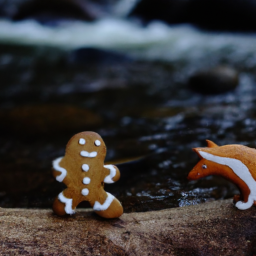

The gingerbread man joyfully balancing atop the fox’s tail in the middle of a stream, enjoying his adventurous     
crossing.

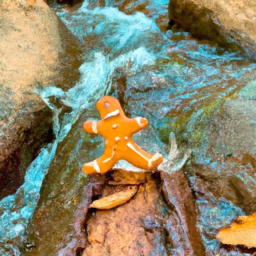

A serene woodland setting with friends, including the gingerbread man, gathered around a campfire enjoying each    
other's company.

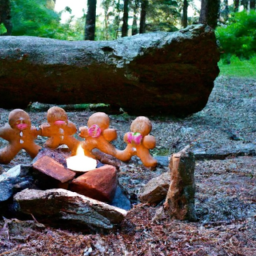

The gingerbread man raising an arm victoriously among friends, as night falls with a twinkling starry sky.

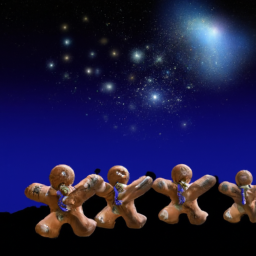

Editor:

The illustrations beautifully capture the whimsical and adventurous spirit of the gingerbread man’s story. Here are
a few suggestions to enhance the book:                                                                             

 1 Consistency in Characters:                                                                                      
    • Ensure the gingerbread man looks uniform throughout, emphasizing his distinct features like button eyes or   
      scarf.                                                                                                       
 2 Emotion and Expression:                                                                                         
    • Add more expression to the gingerbread man and other characters to reflect the excitement and dynamics of    
      each scene.                                                                                                  
 3 Color Palette:                                                                                                  
    • Brighten the colors slightly to make the images more engaging, especially in outdoor scenes like the garden  
      and meadow.                                                                                                  
 4 Details in Setting:                                                                                             
    • Add small details to the surroundings to create a richer environment, such as more flowers in the garden or  
      stars in the night sky.                                                                                      
 5 Fox Illustration:                                                                                               
    • Emphasize the friendly demeanor of the fox to match the story’s tone of forming a new friendship.            

Once these adjustments are made, the book should be visually appealing and engaging for young readers. Let me know 
when these are ready for final review!

Illustrator:

A cozy kitchen with a grandmotherly figure rolling out dough. There's a sense of warmth and care in her expression 
as she carefully shapes dough into a gingerbread man. The kitchen is quaint, with flour dusted surfaces and a      
window showing a sunny day outside.

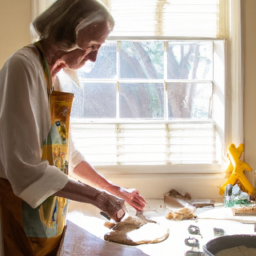

The gingerbread man springing from the baking tray with tiny arms up in excitement. The kitchen is still in view,  
with the grandmother's surprised yet joyful face in the background. The gingerbread man has a wide, cheerful grin  
and button eyes.

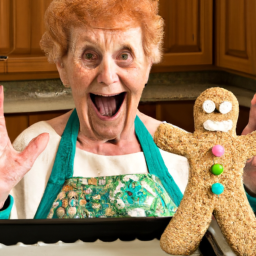

The gingerbread man sprinting through a colorful garden, passing a curious rabbit. The garden is vibrant with      
tulips and alliums, and the rabbit pauses mid-hop with wide, curious eyes watching the gingerbread man dash by.

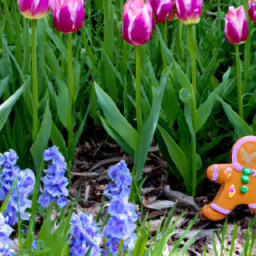

The gingerbread man crossing a tiny wooden bridge, with a playful dog chasing closely behind. The setting includes 
lush greenery and a small stream under the bridge. The dog looks enthusiastic, with a wagging tail and bright eyes.

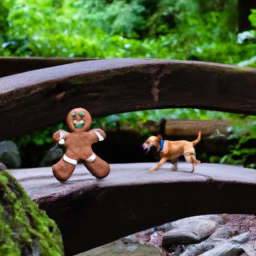

The gingerbread man hopping over a sunny meadow, pursued by a tired rooster. The meadow is bright and full of      
wildflowers, with a clear blue sky. The rooster looks determined yet slightly winded.

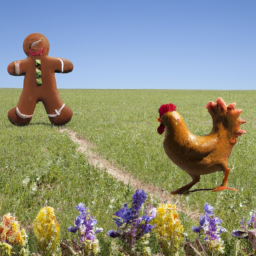

The gingerbread man standing beside a gentle river, thinking about crossing it, and a sly fox nearby offering help.
The scene is tranquil, with the river flowing calmly and trees lining its banks. The fox has a charming, friendly  
look.

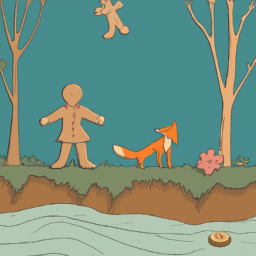

The gingerbread man merrily dancing atop the fox's tail in mid-stream. The scene is playful, with water gently     
splashing around them. The fox appears trustworthy, guiding the gingerbread man safely across.

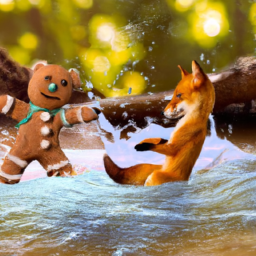

A serene woodland setting with friends gathered around a campfire. The gingerbread man is at the center, wearing a 
crown of leaves, with the rabbit, dog, rooster, and fox sitting around him. The scene is cozy, with a warm glow    
from the fire and stars beginning to twinkle in the sky.

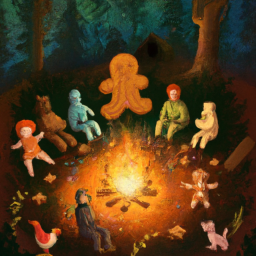

The gingerbread man raising an arm in triumph, surrounded by his new friends as night falls. The sky is twinkling  
with stars, and the woodland setting is peaceful with trees silhouetted against the night sky.

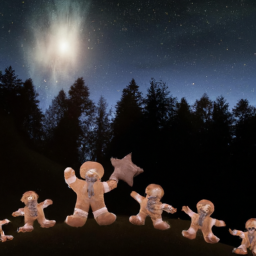

User:                                                       

APPROVE

In [20]:
runtime.start()
session_id = str(uuid.uuid4())
await runtime.publish_message(
    GroupChatMessage(
        body=UserMessage(content="Please create a picture book for a very short story about the gingerbread man.", source="User")
    ),
    TopicId(type=group_chat_topic_type, source=session_id),
)
await runtime.stop_when_idle()

From the output, you can see the writer, illustrator, and editor agents
taking turns to speak and collaborate to generate a picture book, before
asking for final approval from the user.

## Next Steps

This example showcases a simple implementation of the group chat pattern -- 
**it is not meant to be used in real applications.** You can improve the
speaker selection algorithm. For example, you can avoid using LLM when simple
rules are sufficient and more reliable: 
you can use a rule that the editor always speaks after the writer.

The [AgentChat API](../../agentchat-user-guide/index.md) provides a high-level
API for selector group chat. It has more features but mostly shares the same
design as this implementation.